In [ ]:
# Copyright © 2016 by Marena Trinidad. All rights reserved.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

/Users/marenaisabelle/anaconda/envs/my-rdkit-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:
chem_lib = pd.read_csv("/Users/marenaisabelle/CODE/GADSI/fulldf")

In [8]:
chem_lib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10466 entries, 0 to 10465
Data columns (total 3 columns):
PC_CID      10466 non-null float64
Activity    10466 non-null float64
Smiles      10466 non-null object
dtypes: float64(2), object(1)
memory usage: 245.4+ KB


0.0    10225
1.0      241
Name: Activity, dtype: int64


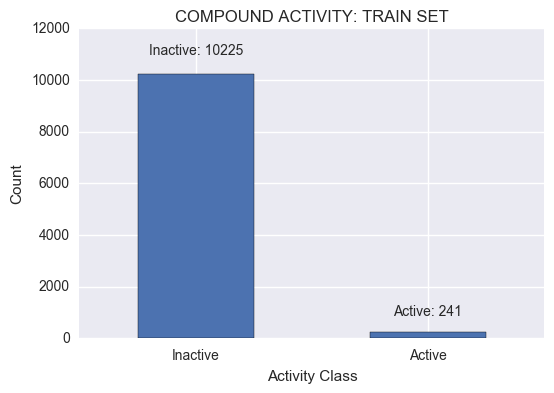

In [9]:
# ACTIVE COMPOUND STATISTICS
print chem_lib.Activity.value_counts()

ax = chem_lib.Activity.value_counts().plot(kind='bar')
group_labels = ['Inactive', 'Active']
ax.set_title('COMPOUND ACTIVITY: TRAIN SET')
ax.set_xlabel('Activity Class')
ax.set_xticklabels(group_labels, rotation ='horizontal')
ax.set_ylabel('Count')
ax.annotate('Active: 241', xy=(1.0, 241), xytext=(.85, 900), )
ax.annotate('Inactive: 10225', xy=(-0.2000, 241), xytext=(-.20, 11000), )

In [10]:
# DEFINE FX: FINGERPRINT GENERATOR
def make_fingerprints(smiles, radius = 2):
    from rdkit import Chem
    from rdkit import DataStructs
    from rdkit.Chem import AllChem

    mols, np_fps, bit_fps, arr = [], [], [], []

    for m in smiles:
        mol = Chem.MolFromSmiles(m)
        mols.append(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius)
        bit_fps.append(fp)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        np_fps.append(arr)
    return mols, bit_fps, np_fps

In [11]:
# GENERATE FINGERPRINTS
train_mol, train_bit, train_fps = make_fingerprints(chem_lib.Smiles)

In [12]:
def includeRingMembership(s, n):
    r=';R]'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def includeDegree(s, n, d):
    r=';D'+str(d)+']'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def writePropsToSmiles(mol,smi,order):
    finalsmi = smi
    for i,a in enumerate(order):
        atom = mol.GetAtomWithIdx(a)
        if atom.IsInRing():
            finalsmi = includeRingMembership(finalsmi, i+1)
        finalsmi = includeDegree(finalsmi, i+1, atom.GetDegree())
    return finalsmi
 
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, 
                                   rootedAtAtom=atomID)
    order = eval(mol.GetProp("_smilesAtomOutputOrder"))
    smi2 = writePropsToSmiles(mol,smi,order)
    return smi,smi2

def _prepareMol(mol,kekulize):
    from rdkit.Chem import rdDepictor
    
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    from IPython.display import SVG
    from rdkit.Chem.Draw import rdMolDraw2D
    
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))  
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(.1,.1,1)})

def depictBit(bitId,examples,mols,molSize=(450,200)):
    zid = examples[bitId]
    info={}
    fp = Chem.GetMorganFingerprintAsBitVect(mols[zid],2,2048,bitInfo=info)
    aid,rad = info[bitId][0]
    return getSubstructDepiction(mols[zid],aid,rad,molSize=molSize)

In [13]:
# CALCULATE BIT FREQUENCIES
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
import pickle
from collections import Counter
%pylab inline

numBitCount = Counter()
fpBitCount = Counter()

for i in range(len(train_bit)):
    fp = train_bit[i]
    numBitCount[fp.GetNumOnBits()]+=1
    for bit in fp.GetOnBits():
        fpBitCount[bit]+=1

Populating the interactive namespace from numpy and matplotlib


In [14]:
# FIND BIT FREQ STATS
freqs = [y for x,y in fpBitCount.items()]
mew = np.mean(freqs)
sigma = np.std(freqs)
usage_percentile = [np.percentile(sorted([y for x,y in fpBitCount.items()]),z) for z in (1,25,50,75,99)]
minfreq_bit = min([y for x,y in fpBitCount.items()])
maxfreq_bit = max([y for x,y in fpBitCount.items()])
print mew, sigma, usage_percentile, minfreq_bit, maxfreq_bit

231.51953125 681.522786992 [13.469999999999999, 46.0, 84.0, 178.0, 2944.9199999999955] 3 10301


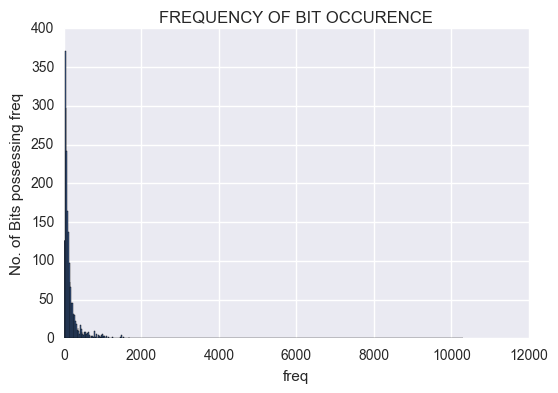

In [15]:
# PLOT DISTRIBUTION OF BIT FREQ
g = hist(sorted([y for x,y in fpBitCount.items()],reverse=True),bins=500)
_=xlabel("freq")
_=ylabel("No. of Bits possessing freq")
_=title("FREQUENCY OF BIT OCCURENCE")

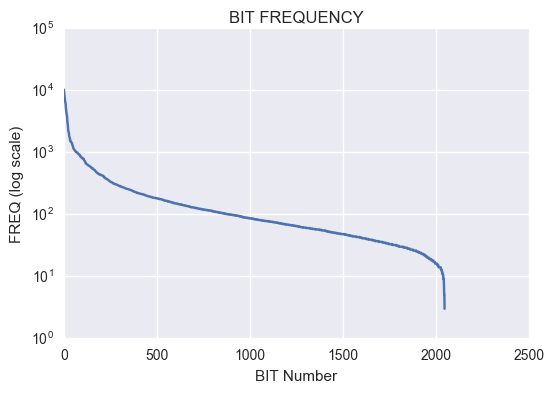

In [16]:
# PLOT FREQ OF EACH BIT, SORTED
plot(sorted([y for x,y in fpBitCount.items()],reverse=True))
_=yscale("log")
_=xlabel("BIT Number")
_=ylabel("FREQ (log scale)")
_=title("BIT FREQUENCY")

In [17]:
# ID EXAMPLE MOLS FOR EACH BIT FRAGMENT
keepMols={}
bitExamples={}
needed = list(range(len(fpBitCount)))
suppl = chem_lib['Smiles']

for i in range(len(train_mol)):
    m = train_mol[i]
    fp = Chem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
    mid = chem_lib.PC_CID[i]
    for bit in fp.GetOnBits():
        if bit in needed:
            bitExamples[bit] = mid
            keepMols[mid]=m
            needed.remove(bit)
    if not len(needed):
        break
        
pickle.dump((keepMols,bitExamples,numBitCount,fpBitCount),open("BIT_analysis.pkl",'wb+'))
(keepMols,bitExamples,numBitCount,fpBitCount) = pickle.load(open("BIT_analysis.pkl",'rb'))

In [18]:
 # GENERATE BIT COUNT LIST: (COUNT, BITID)
itms = [(y,x) for x,y in fpBitCount.items()]

In [19]:
# CREATE IMAGE AND STATS DATAFRAME FOR ALL BITS
import pandas as pd
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

rows_c = []
for bCount,bitId in sorted(itms,reverse=True):
    pccid = bitExamples[bitId]    
    if pccid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[pccid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[pccid],aid,rad)
        svg = depictBit(bitId,bitExamples,keepMols,molSize=(250,125))
        rows_c.append([bitId,
                       rad,pccid,svg.data,bCount])
train_bit_df = pd.DataFrame(rows_c,columns=('Bit_ID','Radius', 'PC_CID','drawing','counts'))

In [20]:
# ID TOP PREDICTIVE FRAGMENTS BY INFO GAIN
from rdkit.ML.InfoTheory import InfoBitRanker
from rdkit.Chem import FragmentCatalog
from rdkit import Chem
from rdkit import RDConfig

ranker = InfoBitRanker(2048,2)
acts = [x for x in chem_lib.Activity]

for i,fp in enumerate(train_bit):
    act = int(acts[i])
    ranker.AccumulateVotes(fp,act)

# Collect Top 20 Bits
top20 = ranker.GetTopN(20)
top20_bitids = []
for id,gain,n0,n1 in top20:
    top20_bitids.append(id)
    print(int(id),'%.3f'%gain,int(n0),int(n1)) # bitId, infoGain, nInactive, nActive

# Collect Top 500 Bits for PCA
top500 = ranker.GetTopN(500)
topbit50 = []

(650, '0.005', 8334, 138)
(2044, '0.005', 64, 22)
(1585, '0.003', 33, 14)
(1070, '0.003', 382, 37)
(525, '0.003', 146, 21)
(453, '0.003', 27, 11)
(1257, '0.002', 306, 27)
(1516, '0.002', 78, 14)
(1950, '0.002', 141, 18)
(1332, '0.002', 34, 10)
(397, '0.002', 112, 16)
(4, '0.002', 164, 19)
(816, '0.002', 489, 34)
(1487, '0.002', 265, 24)
(1296, '0.002', 36, 10)
(950, '0.002', 1066, 4)
(1292, '0.002', 291, 25)
(1683, '0.002', 1287, 61)
(164, '0.002', 40, 10)
(739, '0.002', 402, 29)


In [23]:
# FIND EXAMPLE MOLECULES FOR THE TOP 20 BITS BY INFO GAIN
top_bitids = [int(x) for x in top20_bitids]

topbit_ix = []
topbit_ex = []
for i in top20_bitids:
    mol_ex_ix = train_bit_df.Bit_ID[train_bit_df.Bit_ID==i].index
    topbit_ix.append(mol_ex_ix)
    hit_pccid = train_bit_df.PC_CID.ix[mol_ex_ix]
    topbit_ex.append(hit_pccid)

# Store in DataFrame    
df_rows = [x for x in range(0, 2048)]
drop_bits = [x for x in df_rows if x not in topbit_ix]
topbit_df = train_bit_df.drop(drop_bits, axis=0)

In [25]:
topbit_df.head(10)

Bit_ID  Radius      PC_CID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [131]:
# FIND EXAMPLE MOLECULES FOR TOP 500 FRAGS BY INFO GAIN
topbit500 = [x[0] for x in top500]
subset = chem_lib.copy
for fp in range(0, len(train_fps)):
    temp = train_bit[fp]
    for i in topbit500:
        subset[str(i)] = temp[int(i-1)]

In [207]:
# CLEAN 500 BIT DATAFRAME
subset = subset.drop(['PC_CID', 'Smiles'], axis= 1)
subset.info()

In [509]:
# CAlCULATE CORRELATION MATRIX FOR TOP 500 MOST PREDICTIVE FRAGS
sub_corr = subset.corr()
sub_corr = sub_corr.fillna(0)
legit_corr = [np.absolute(x) for x in sub_corr if x <1 and x > 0]
print len(legit_corr)
# NOTE: No features displayed valid correlation values with activity or eachother
# as all values were NaN, 0 or greater than 1

0


In [506]:
# PCA ANALYSIS FOR FEATURE REDUCTION: TOP 500 BIT SPACE
from sklearn.decomposition import PCA
X = subset
pca = PCA(n_components=50)
pca.fit(X)
print(pca.explained_variance_ratio_) 
print pca.components_
# NOTE: NO PC's captured the structure/variance of data (all ~0) 
# as all values were NaN, 0 or greater than 1

[  1.00000000e+00   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33   9.98402083e-33   9.98402083e-33
   9.98402083e-33   9.98402083e-33]
[[ 1. -0. -0. ..., -0. -0. -0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 

In [ ]:
# COMPLETE 2048 BIT-SPACE CORRELATION CALCULATIONS

# Generate Bit-wise feature df
bitdf = chem_lib
for fp in range(0, len(train_fps)):
    temp = train_bit[fp]
    for i in range(0, 2048):
        bitdf[str(i)] = temp[int(i)]
cols = bitdf.columns        

# Calculate Correlation Matrix across all bits
x = chem_lib[[cols[1:]]]
y = chem_lib.Activity.values()
fullbit_corr = bitdf.corr(x, y)
# NOTE: No valid correlations exist across the feature space. All cor. coefficients returned are NAN or > 1

In [507]:
# RDKIT CORRELATION IMPLEMENTATION
from rdkit.ML.InfoTheory import rdInfoTheory
topbit50 = [int(x) for x in topbit50]
cr = rdInfoTheory.BitCorrMatGenerator()
allbits = [x for x in range(0,2047)]
cr.SetBitList(topbit50)

for fp in train_bit[:100]:
    cr.CollectVotes(fp)
corrMat = cr.GetCorrMatrix() # Returns 1-D array of correlation-matrix's bottom triangle
legit_corr = [np.absolute(x) for x in corrMat if x <1 and x > 0]
print len(legit_corr)
# NOTE: No valid correlations exist across the feature space. All cor. coefficients returned are NAN or > 1

0
